In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from utils import *

## Data preparation

In [2]:
data = pd.read_csv("data/train_users_processed.csv")
test_data = pd.read_csv("data/test_users.csv")

In [3]:
df = encode_data(data)
cat_type = CategoricalDtype(df["country_destination"].unique(), ordered=True)
df["country_destination"] = df["country_destination"].astype(cat_type).cat.codes

In [4]:
cleared_test_data = clear_data(test_data)
test_df = encode_data(cleared_test_data)

In [5]:
X = df.drop(["country_destination"], axis=1)
Y = df["country_destination"]

cols_not_in_test = set(X).difference(set(test_df.columns))
cols_not_in_X = set(test_df).difference(set(X.columns))

# dealing with missing unique values in both dataframes

for col in cols_not_in_test:
    test_df[col] = 0
    
for col in cols_not_in_X:
    X[col] = 0
    
test_df.columns = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

### Base tree model training

In [6]:
tree = DecisionTreeClassifier(max_depth=8, criterion="entropy")
tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=8)

Accuracy: 0.6369930972791934
Precision: 0.2516664992075338
Recall: 0.15454486217200192
F1: 0.17120633568609334


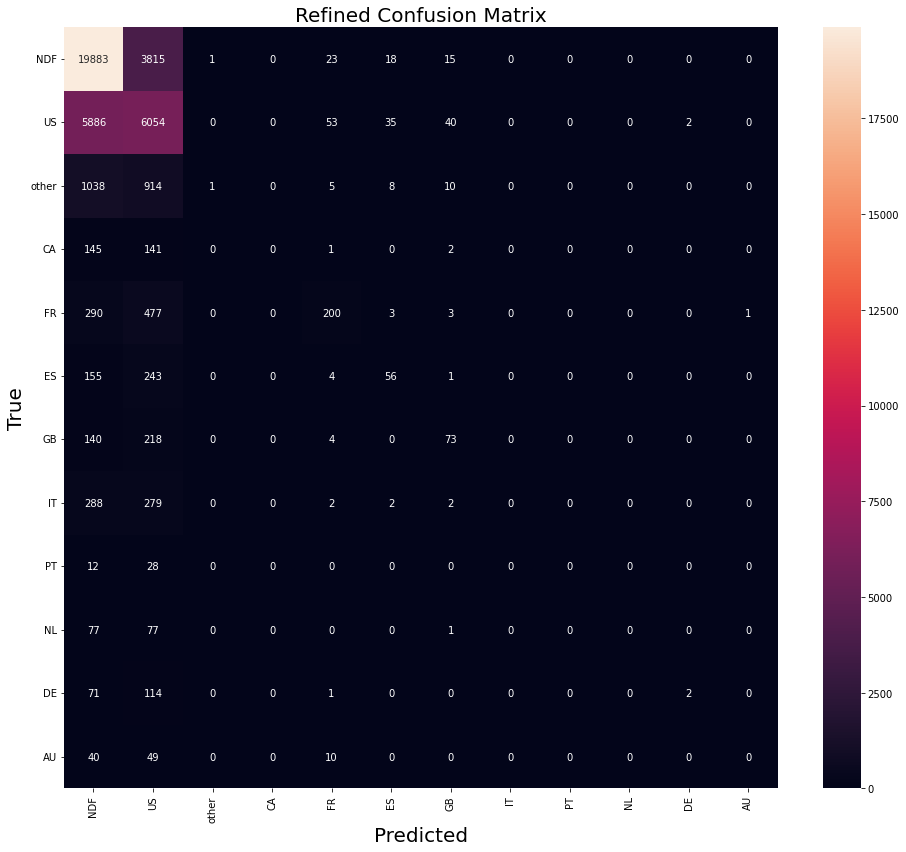

In [7]:
evaluate_metrics(tree, X_test, y_test)

In [8]:
weights = {0: 1,
           1: 1,
           2: 1,
           4: 1,
           7: 1,
           6: 1,
           5: 1,
           3: 1,
           10: 1,
           9: 1,
           11: 1,
           8: 1}

In [9]:
tree_weigths = DecisionTreeClassifier(max_depth=8, criterion="entropy", class_weight=weights)
tree_weigths.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1,
                                     7: 1, 8: 1, 9: 1, 10: 1, 11: 1},
                       criterion='entropy', max_depth=8)

Accuracy: 0.6370174756304923
Precision: 0.2515325529328557
Recall: 0.1545483702053984
F1: 0.17117309741064524


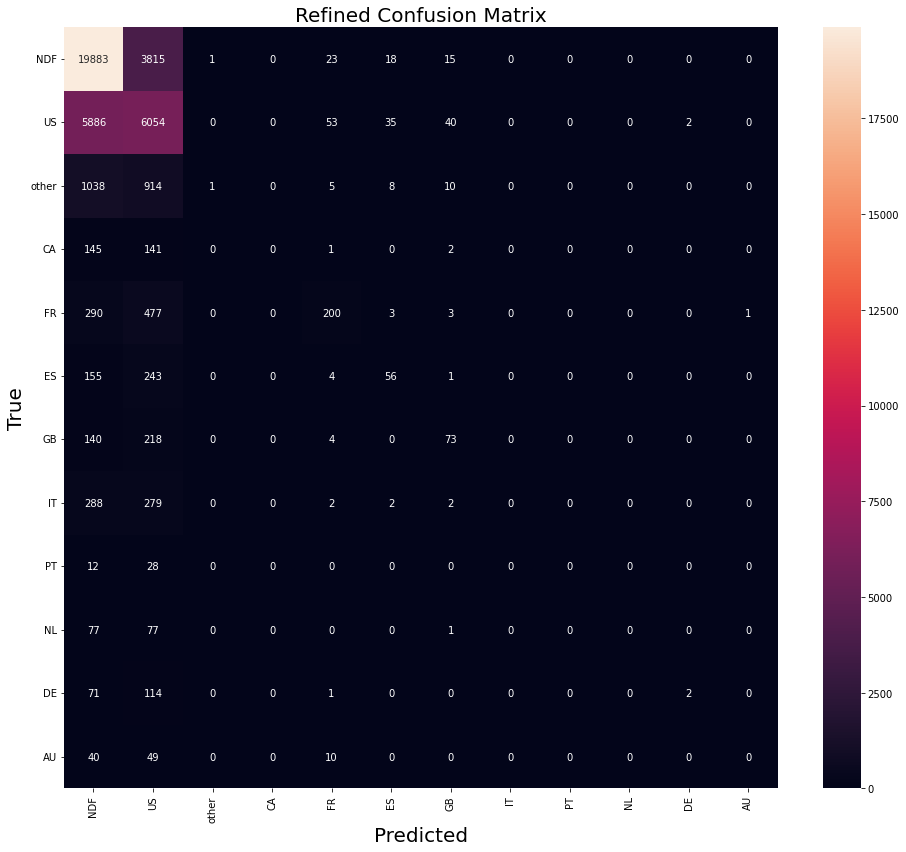

In [10]:
evaluate_metrics(tree_weigths, X_test, y_test)

### Tree model with random oversampling

In [11]:
strategy_over = {3: 15000,
                 4: 15000,
                 5: 15000,
                 6: 15000,
                 7: 15000,
                 8: 15000,
                 9: 15000,
                 10: 15000,
                 11: 15000}

ros = RandomOverSampler(sampling_strategy=strategy_over, random_state=0)
X_train_os, y_train_os = ros.fit_resample(X_train, y_train)

In [12]:
tree_os = DecisionTreeClassifier(max_depth=8, criterion="entropy")
tree_os.fit(X_train_os, y_train_os)

DecisionTreeClassifier(criterion='entropy', max_depth=8)

Accuracy: 0.63711500687133
Precision: 0.2519569924761306
Recall: 0.1545657984757066
F1: 0.17125703131966838


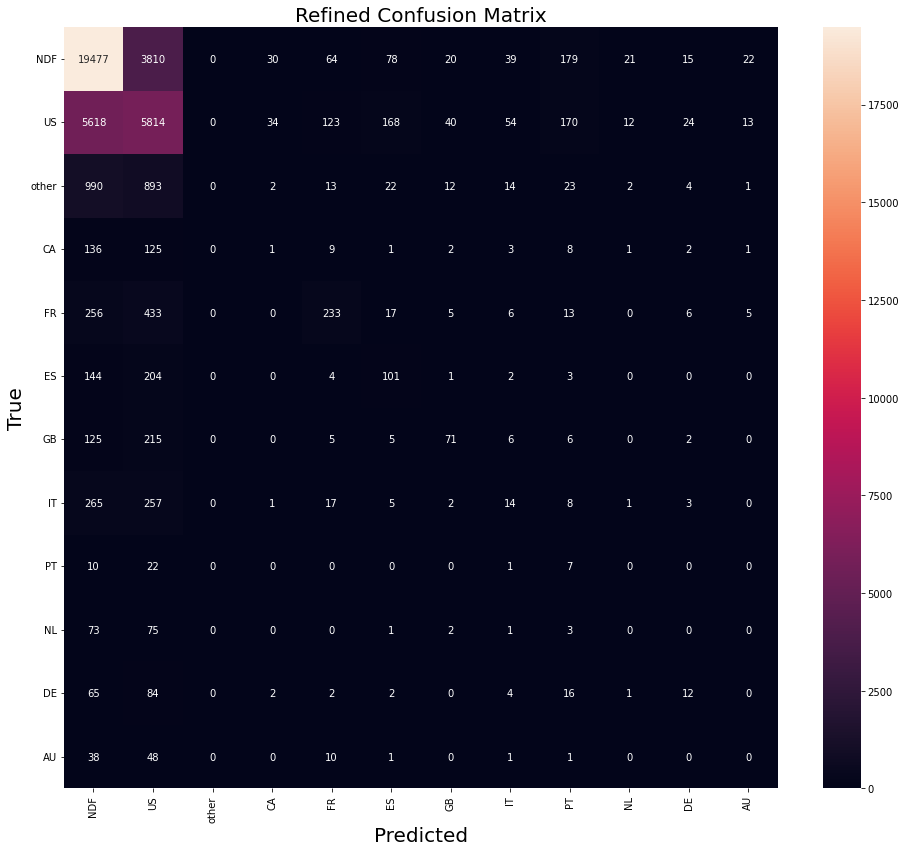

In [13]:
evaluate_metrics(tree_os, X_test, y_test)

### Tree model with undersampling

In [14]:
strategy_under = {0: 15000,
                  1: 15000}

rus = RandomUnderSampler(sampling_strategy=strategy_under, random_state=0)
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)

In [15]:
tree_us = DecisionTreeClassifier(max_depth=8, criterion="entropy")
tree_us.fit(X_train_us, y_train_us)

DecisionTreeClassifier(criterion='entropy', max_depth=8)

Accuracy: 0.6369930943065863
Precision: 0.2514774458971202
Recall: 0.15454146603527966
F1: 0.17116515400689208


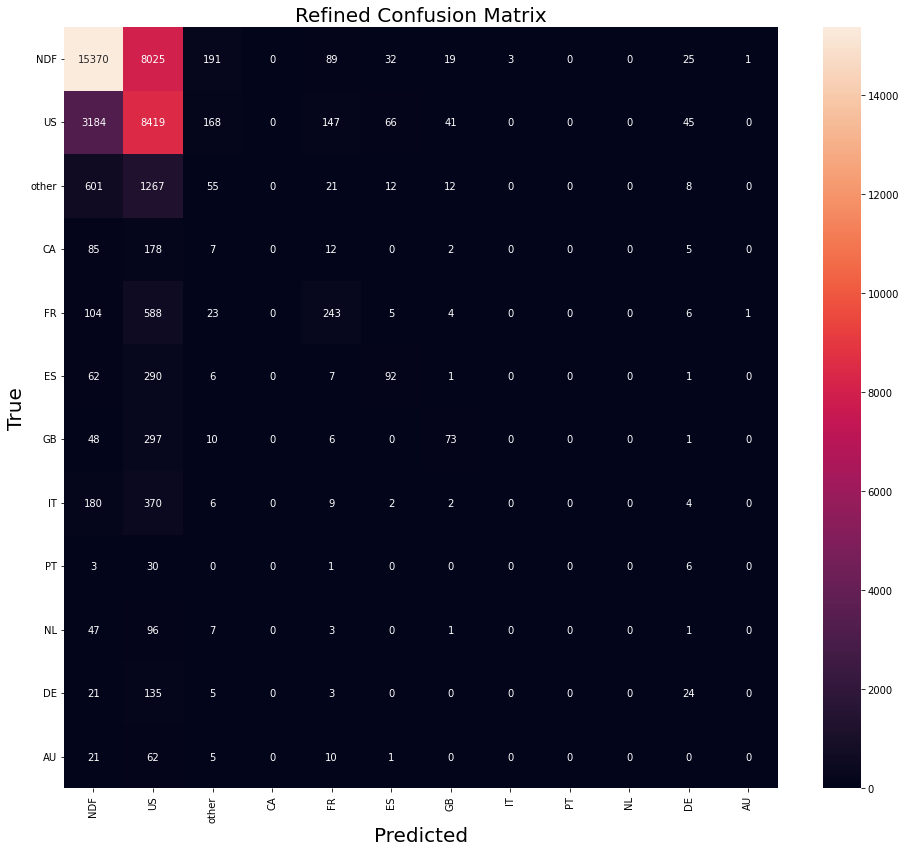

In [16]:
evaluate_metrics(tree_us, X_test, y_test)

### Tree model with oversampling using SMOTE

In [17]:
strategy_smote = {3: 25000,
                  4: 25000,
                  5: 25000,
                  6: 25000,
                  7: 25000,
                  8: 25000,
                  9: 25000,
                  10: 25000,
                  11: 25000}

smote = SMOTENC(categorical_features=list(range(1, len(X.columns))),
                sampling_strategy=strategy_smote)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [18]:
tree_sm = DecisionTreeClassifier(max_depth=8, criterion="entropy")
tree_sm.fit(X_train_sm, y_train_sm)

DecisionTreeClassifier(criterion='entropy', max_depth=8)

Accuracy: 0.6370174756304923
Precision: 0.25176149875145154
Recall: 0.15454497406867612
F1: 0.17120366219972474


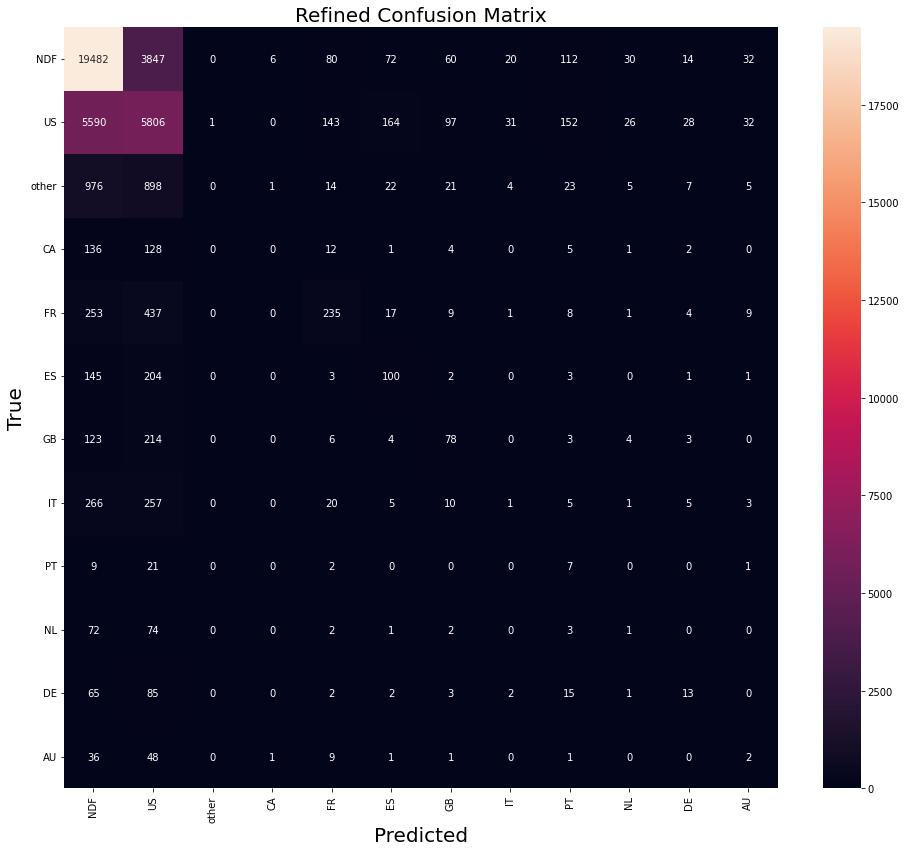

In [19]:
evaluate_metrics(tree_sm, X_test, y_test)

### Tree model with undersampling using NearMiss

In [20]:
strategy_nearmiss = {0: 50000,
                     1: 30000}

nm = NearMiss(sampling_strategy=strategy_nearmiss)
X_train_nm, y_train_nm = nm.fit_resample(X_train, y_train)

In [21]:
tree_nm = DecisionTreeClassifier(max_depth=8, criterion="entropy")
tree_nm.fit(X_train_nm, y_train_nm)

DecisionTreeClassifier(criterion='entropy', max_depth=8)

Accuracy: 0.6370174756304923
Precision: 0.2513486582367659
Recall: 0.1545483702053984
F1: 0.1711370223745702


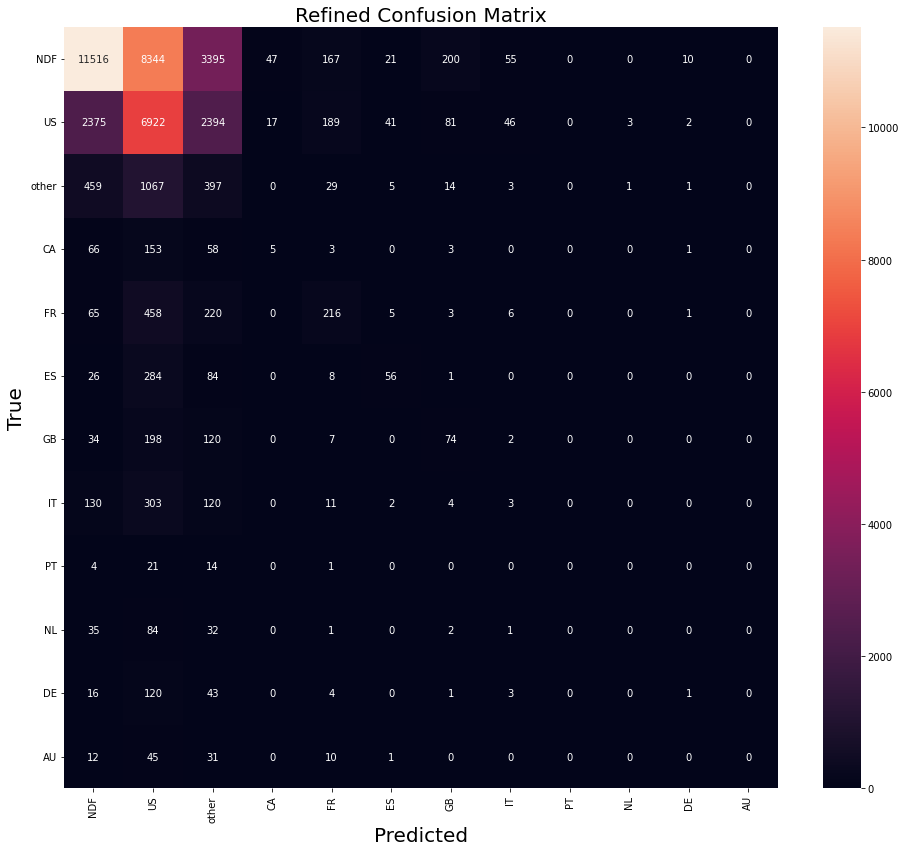

In [22]:
evaluate_metrics(tree_nm, X_test, y_test)

### Tree OnevsRest model training

In [23]:
tree_ovr = OneVsRestClassifier(DecisionTreeClassifier(max_depth=7, criterion="entropy"))
tree_ovr.fit(X_train, y_train)

OneVsRestClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=7))

Accuracy: 0.6388461938277201
Precision: 0.25791501530189376
Recall: 0.160225714806682
F1: 0.17759353962917027


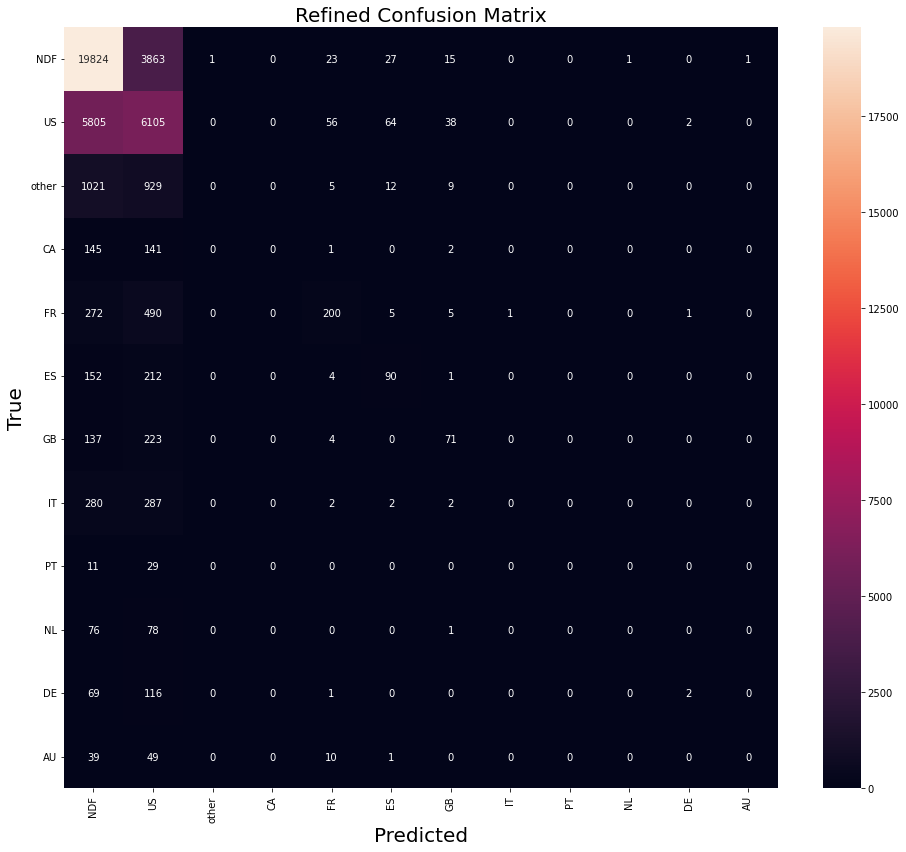

In [30]:
evaluate_metrics(tree_ovr, X_test, y_test)

### Random forest model training

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
forest = RandomForestClassifier(n_estimators=100,
                                max_depth=15,
                                criterion="entropy")
forest.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=15)

Accuracy: 0.6255332299876729
Precision: 0.23017477175648288
Recall: 0.15383750746341698
F1: 0.16852968551766623


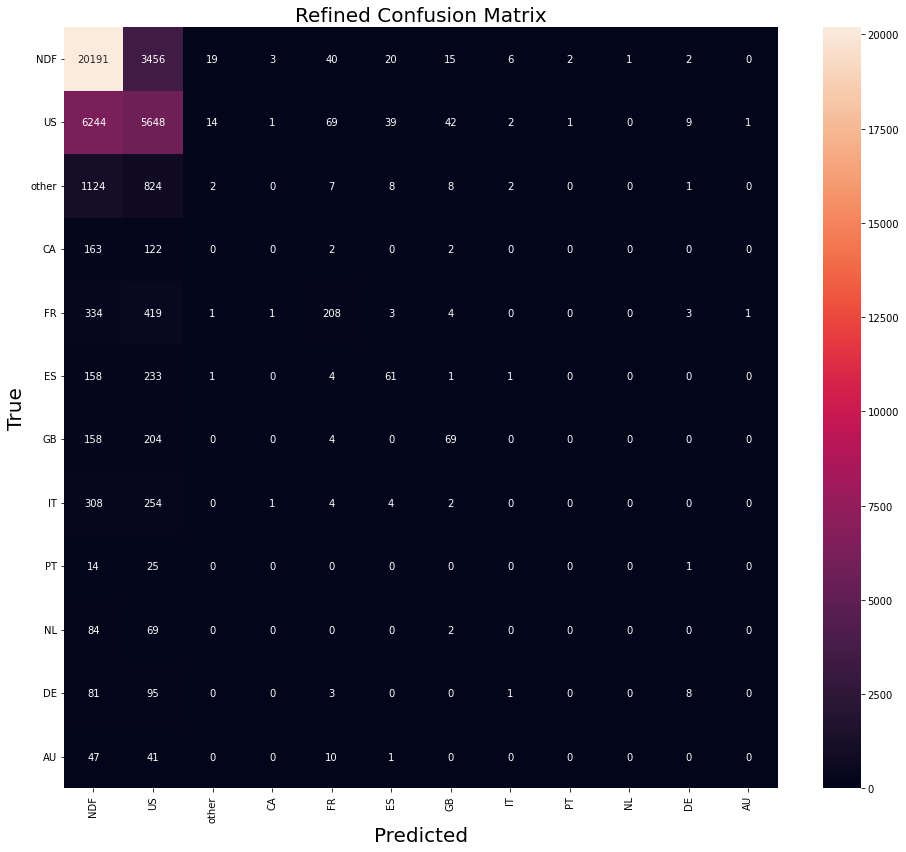

In [33]:
evaluate_metrics(forest, X_test, y_test)

### XGBoost model training

In [34]:
from xgboost import XGBClassifier

In [35]:
xgb_model = XGBClassifier(n_estimators=30, max_depth=6)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=30, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, ...)

Accuracy: 0.6408212356396692
Precision: 0.2592503519587014
Recall: 0.15805392301188148
F1: 0.17606039693811362


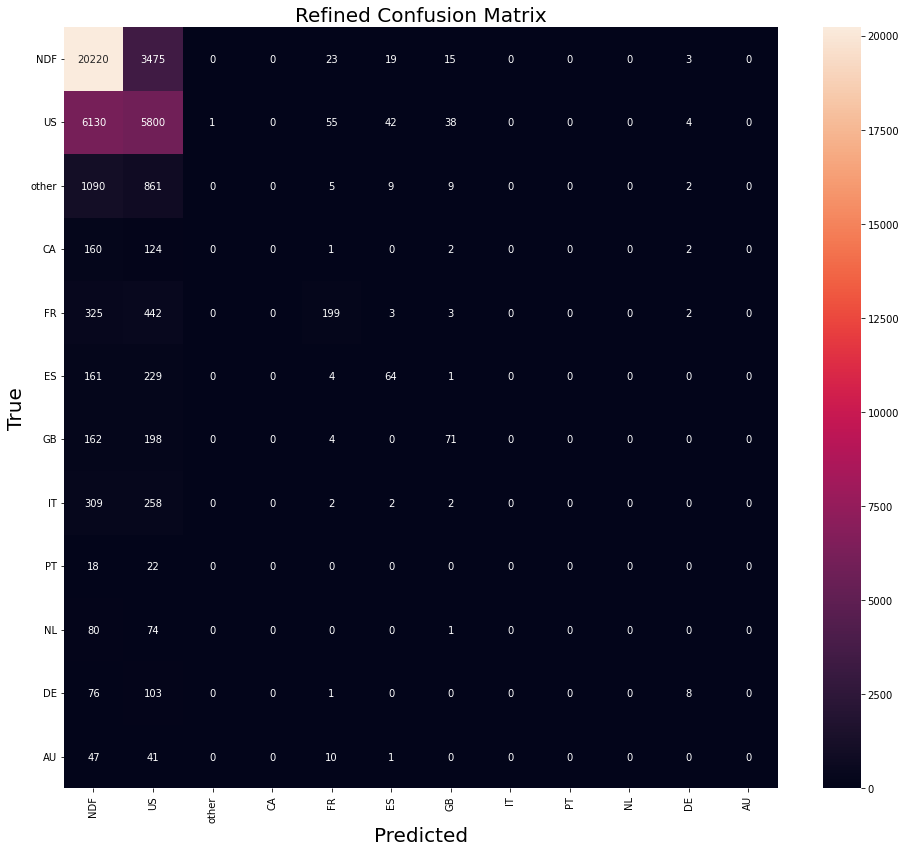

In [36]:
evaluate_metrics(xgb_model, X_test, y_test)

### Run model on test data

In [31]:
y_test_pred = tree.predict(test_df)
y_test_pred = pd.Series(y_test_pred)
categories = cat_type.categories

y_test_pred = y_test_pred.apply(lambda x: categories[x])

In [32]:
submission = pd.DataFrame({"id": test_data["id"], "country": y_test_pred})

In [33]:
submission.to_csv("submissions/submission_0.csv")